In [19]:
import os
import gc
import fnmatch

import numpy as np
np.str = str
np.object = object

import uproot3 as uproot
import awkward as ak
import h5py
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
file_name = "/global/cfs/cdirs/m3246/eic/NC_DIS_18x275/minQ2=100/pythia8NCDIS_18x275_minQ2=100_beamEffects_xAngle=-0.025_hiDiv_5.2329.eicrecon.edm4eic.root"

In [3]:
f = uproot.open(file_name)
print("Top‐level keys in file:", f.keys())  # e.g. [b"events"; …]
tree = f["events"]

Top‐level keys in file: [b'events;3', b'events;2', b'podio_metadata;1']


In [11]:
gen_particle_list = [
  'MCParticles.generatorStatus', 
  'MCParticles.momentum.x',
  'MCParticles.momentum.y',
  'MCParticles.momentum.z',
  'MCParticles.vertex.x',
  'MCParticles.vertex.y',
  'MCParticles.vertex.z',
  'MCParticles.charge',
  'MCParticles.mass',
  'MCParticles.PDG',
  'MCParticles.time',
  'MCParticles.simulatorStatus',
]

reco_particle_list = [
  'ReconstructedParticles.energy',  # energy used for sorting (index 1)
  'ReconstructedParticles.momentum.x',
  'ReconstructedParticles.momentum.y',
  'ReconstructedParticles.momentum.z',
  'ReconstructedParticles.referencePoint.x',
  'ReconstructedParticles.referencePoint.y',
  'ReconstructedParticles.referencePoint.z',
  'ReconstructedParticles.charge',
  'ReconstructedParticles.mass',
  'ReconstructedParticles.PDG',
  'ReconstructedParticles.type',
]

xlims = [
    (-1,     2),       # MCParticles.generatorStatus  (all 1’s → just show [0.5,1.5])
    (-7.5,   7.5),      # MCParticles.momentum.x      (peak around 0, tails ~±5)
    (-7.5,   7.5),      # MCParticles.momentum.y      (peak around 0, tails ~±5)
    (-20,   75.0),       # MCParticles.momentum.z      (most in [0, 200])
    (-50.0,    50.0),       # MCParticles.vertex.x        (nearly all near 0, tiny spread ~±1)
    (-50.0,    50.0),       # MCParticles.vertex.y        (same)
    (-250.0, 1500.0),       # MCParticles.vertex.z        (spikes at 0, tails out to ~35k)
    (-1.5,    1.5),       # MCParticles.charge          (only −1,0,+1)
    (0.0,    1.0),        # MCParticles.mass            (electron≈0.0005, muon≈0.105, pion≈0.135, proton≈0.938 → all <1 GeV)
    (-2500.0, 2500.0),    # MCParticles.PDG             (PDG codes run ± a few thousand)
    (0.0,   10.0),       # MCParticles.time            (most times in [0, 120] or so)
    (0.0, 2e8),           # MCParticles.simulatorStatus (large codes up to ≃4×10^8)
]

# sanity check: there must be exactly as many xlim‐tuples as branches:
assert len(xlims) == len(gen_particle_list), "Length of `xlims` must match number of branches."

In [27]:
tree = uproot.open(file_name)['events']
gen_status = tree['MCParticles.generatorStatus'].array()
status_mask = (gen_status == 1)
#status_mask = None

raws = [tree[feat].array() for feat in gen_particle_list]
if status_mask is not None:
  raws = [r[status_mask] for r in raws]

gen_PIDs_jagged = tree['MCParticles.PDG'].array()[status_mask]
gen_PIDs_flat = ak.flatten(gen_PIDs_jagged)
gen_PIDs_np = ak.to_numpy(gen_PIDs_flat)
gen_PIDs = (np.unique(gen_PIDs_np))
print(gen_PIDs)

[-2212 -2112  -321  -211   -16   -14   -13   -12   -11    11    12    13
    14    16    22   130   211   321  2112  2212]


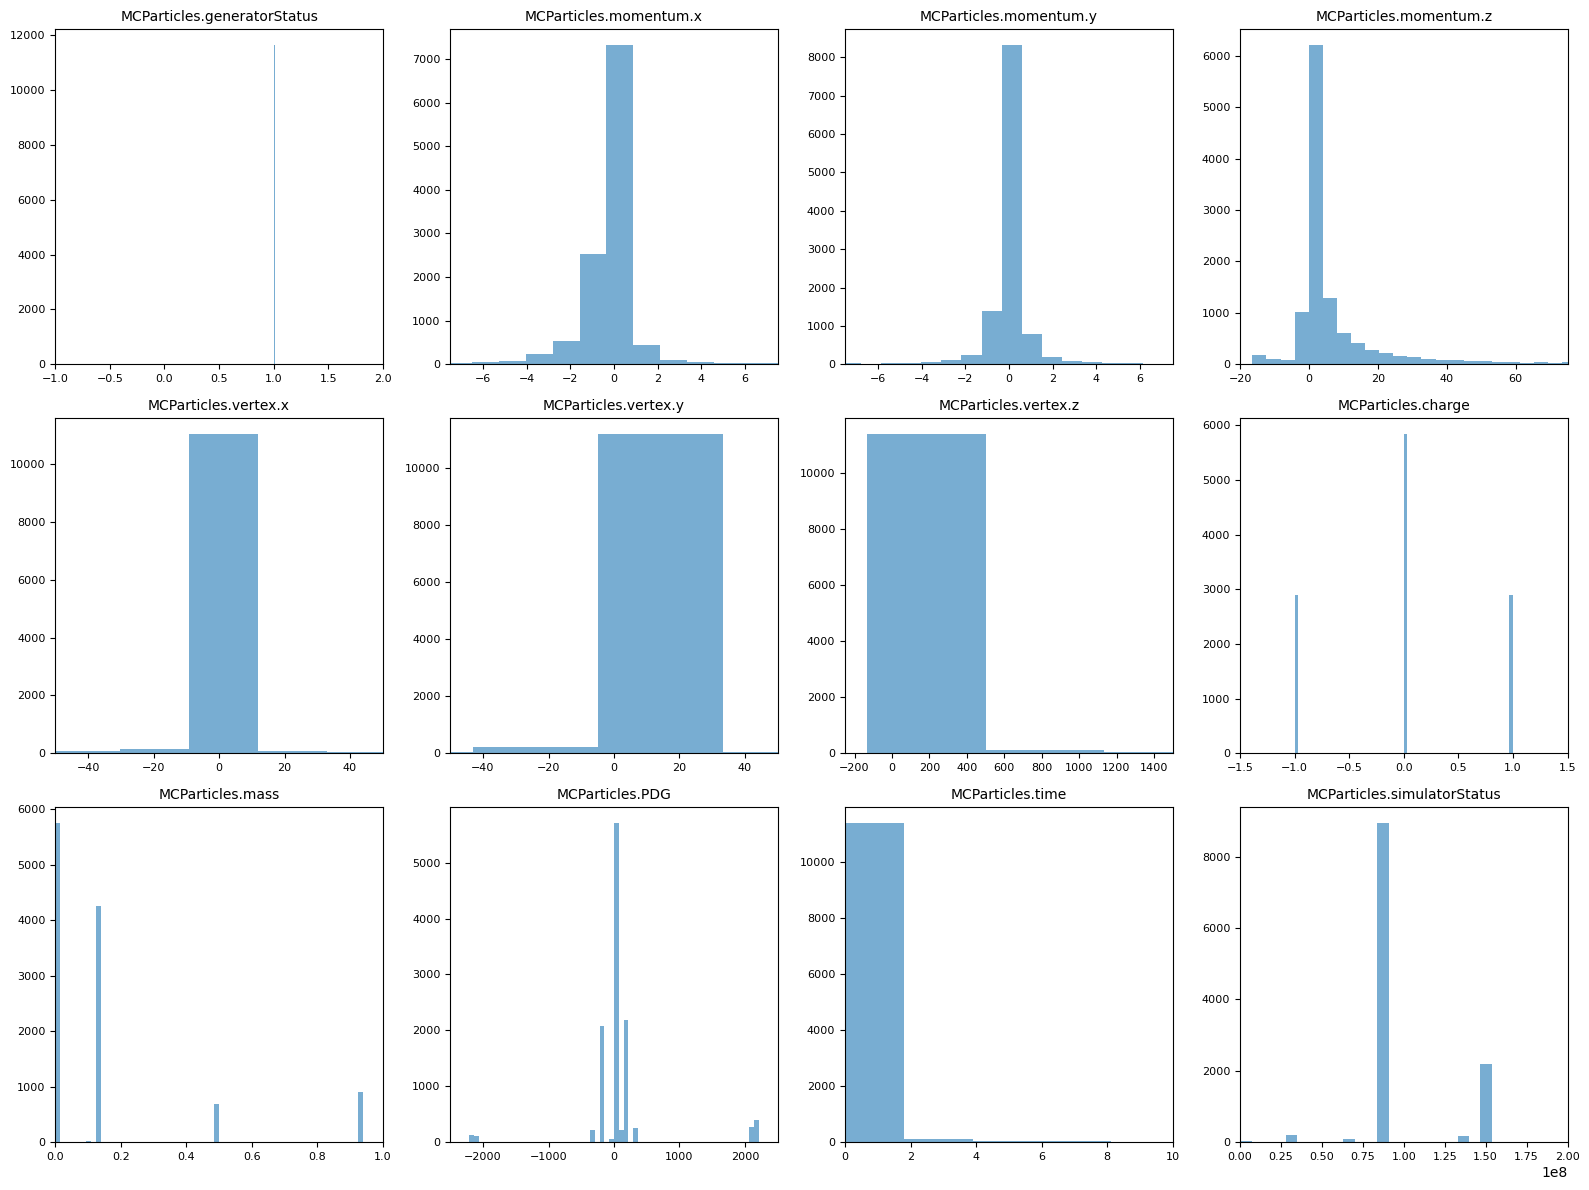

In [6]:

# Make 3×4 subplots and draw a histogram for each (with its corresponding x‐limits).
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, (branch, raw_array, (xmin, xmax)) in enumerate(zip(gen_particle_list, raws, xlims)):
    # flatten the jagged array into 1D
    flat = ak.flatten(raw_array)
    np_vals = ak.to_numpy(flat)

    # draw a simple filled histogram
    axes[idx].hist(np_vals, bins=60, histtype="stepfilled", alpha=0.6)
    axes[idx].set_title(branch, fontsize=10)
    axes[idx].set_xlim(xmin, xmax)
    axes[idx].tick_params(labelsize=8)

# Hide the remaining (empty) subplot if there are fewer than 12 branches.
for j in range(len(gen_particle_list), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [9]:
px_raw = raws[1]   # MCParticles.momentum.x (JaggedArray, shape = (n_events, n_particles(event)))
py_raw = raws[2]   # MCParticles.momentum.y
pz_raw = raws[3]   # MCParticles.momentum.z

sum_px = ak.sum(px_raw, axis=1)   # shape = (n_events,)
sum_py = ak.sum(py_raw, axis=1)
sum_pz = ak.sum(pz_raw, axis=1)

E_Missing = (sum_px**2 + sum_py**2 + sum_pz**2) **0.5
E_Missing_np = ak.to_numpy(E_Missing) 

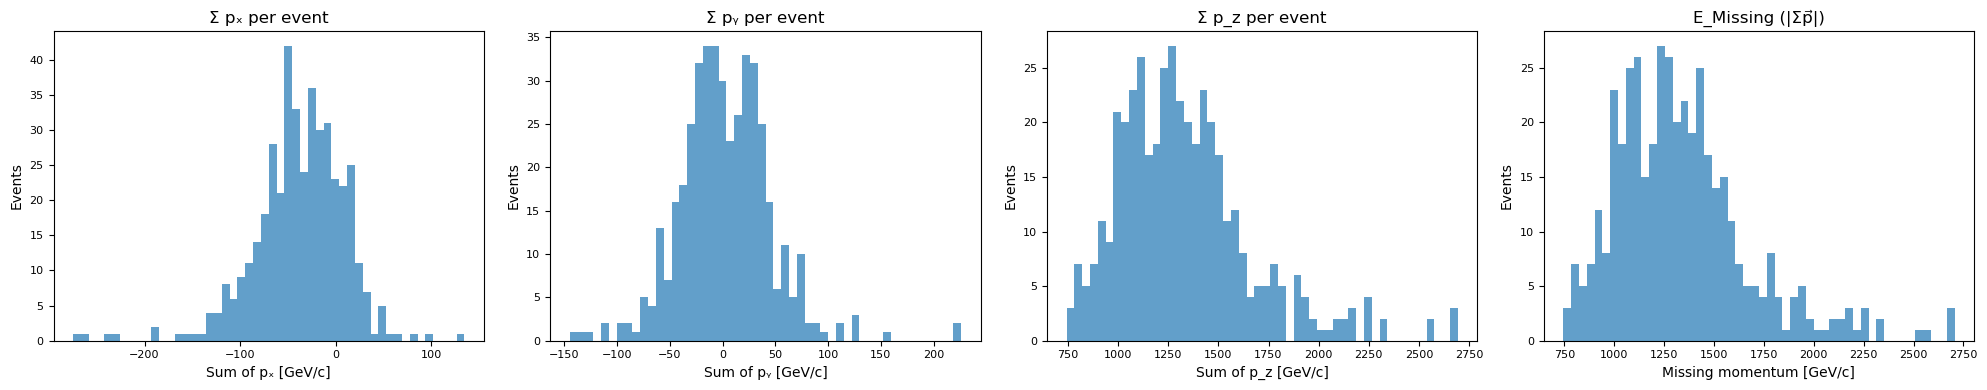

In [10]:
# Convert to NumPy for plotting
sum_px_np    = ak.to_numpy(sum_px)
sum_py_np    = ak.to_numpy(sum_py)
sum_pz_np    = ak.to_numpy(sum_pz)
E_Missing_np = ak.to_numpy(E_Missing)

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# List of (array, title, xlabel) tuples
plot_data = [
    (sum_px_np,    "Σ pₓ per event",    "Sum of pₓ [GeV/c]"),
    (sum_py_np,    "Σ pᵧ per event",    "Sum of pᵧ [GeV/c]"),
    (sum_pz_np,    "Σ p_z per event",   "Sum of p_z [GeV/c]"),
    (E_Missing_np, "E_Missing (|Σp⃗|)", "Missing momentum [GeV/c]"),
]

for ax, (data, title, xlabel) in zip(axes, plot_data):
    ax.hist(data, bins=50, histtype="stepfilled", alpha=0.7)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel("Events", fontsize=10)
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

In [12]:
reco_raws = [tree[feat].array() for feat in reco_particle_list]

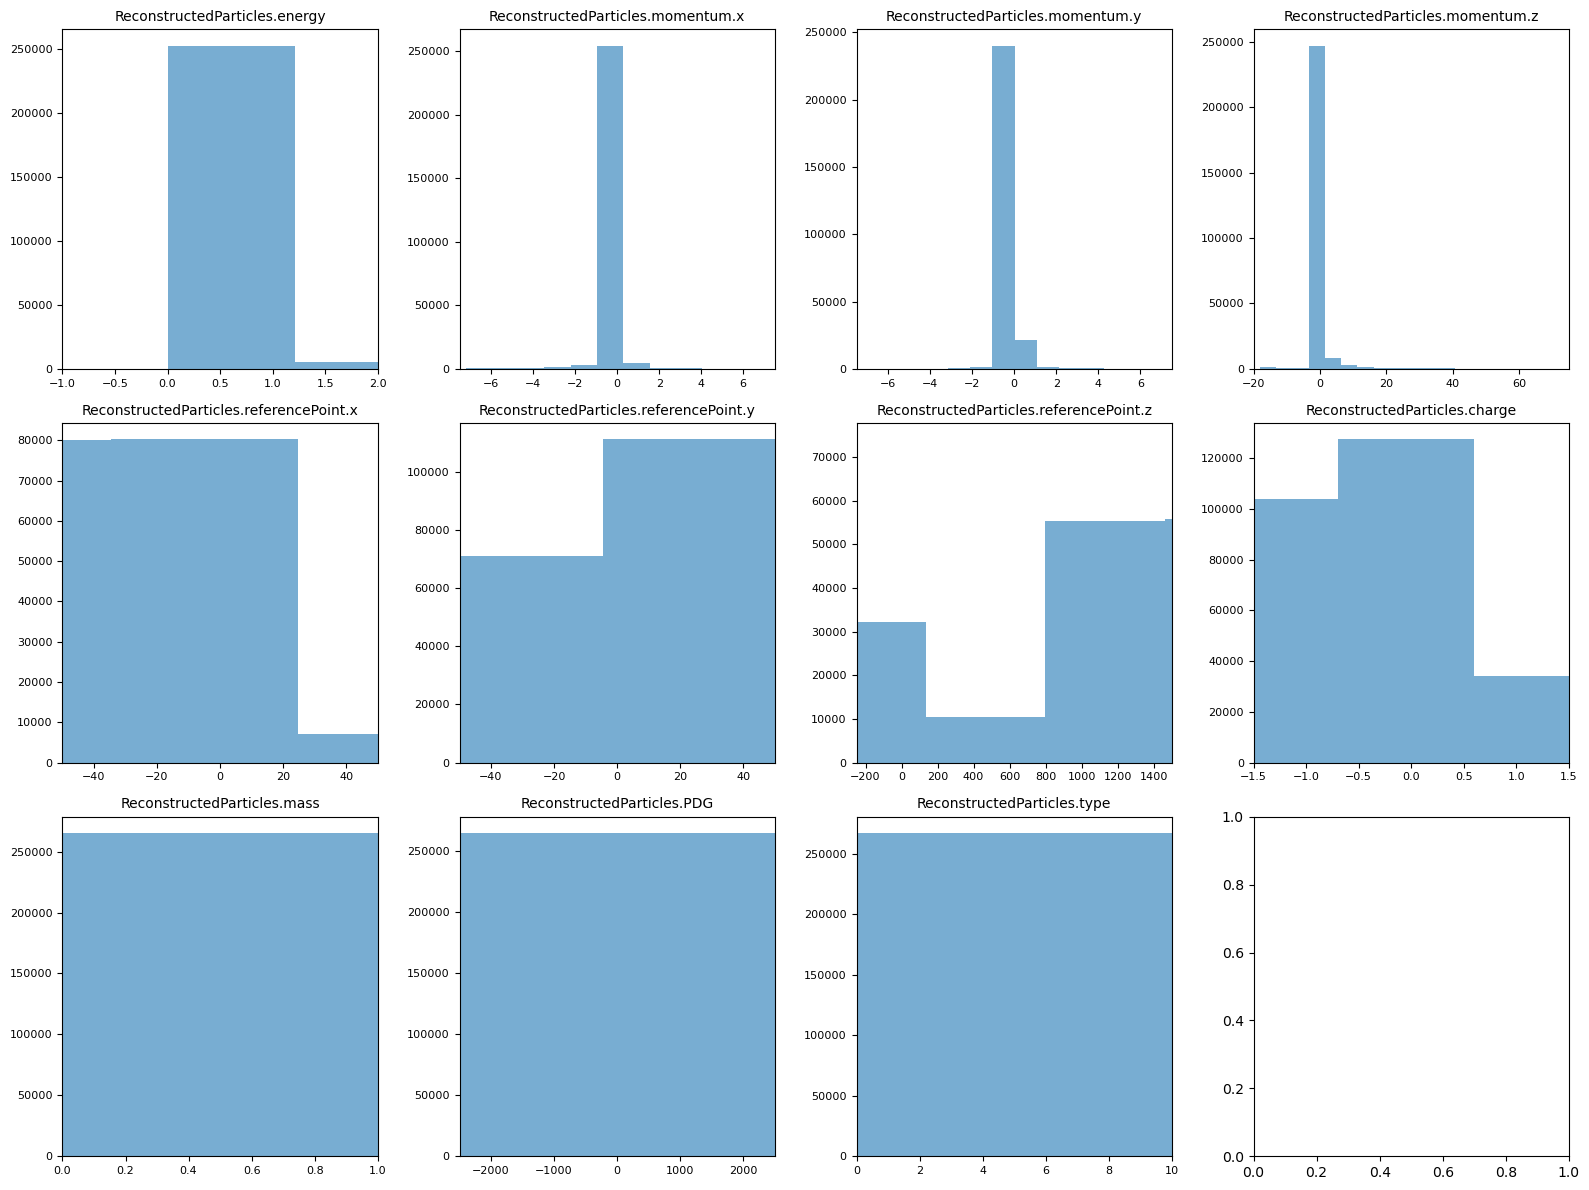

In [13]:
# Make 3×4 subplots and draw a histogram for each (with its corresponding x‐limits).
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, (branch, raw_array, (xmin, xmax)) in enumerate(zip(reco_particle_list, raws, xlims)):
    # flatten the jagged array into 1D
    flat = ak.flatten(raw_array)
    np_vals = ak.to_numpy(flat)

    # draw a simple filled histogram
    axes[idx].hist(np_vals, bins=60, histtype="stepfilled", alpha=0.6)
    axes[idx].set_title(branch, fontsize=10)
    axes[idx].set_xlim(xmin, xmax)
    axes[idx].tick_params(labelsize=8)

# Hide the remaining (empty) subplot if there are fewer than 12 branches.
for j in range(len(reco_particle_list), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()